<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter2ForwardModels/neuralRepresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Representation
## David Brady
## University of Arizona
## September 2023

### libraries

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu, elu, sigmoid, swish, relu
from tensorflow.keras.backend import get_value
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.special import j0
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size']= 22

## Activation functions and peceptrons

  A perceptron operates on a data array $\bf f$ according to $g=o({\bf w}\cdot{\bf f}+b)$, where $o(\cdot )$ is the activation function, ${\bf w}$ is a weight vector and $b$ is a bias value. In typical neural models, the activation function acts as threshold returning positive values above the threshold and zero below threshold. But activation functions may alternatively serve to return frequency or local responses as illustrated by the $\sin(x)$ and Bessel $j0(x)$ functions shown below.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

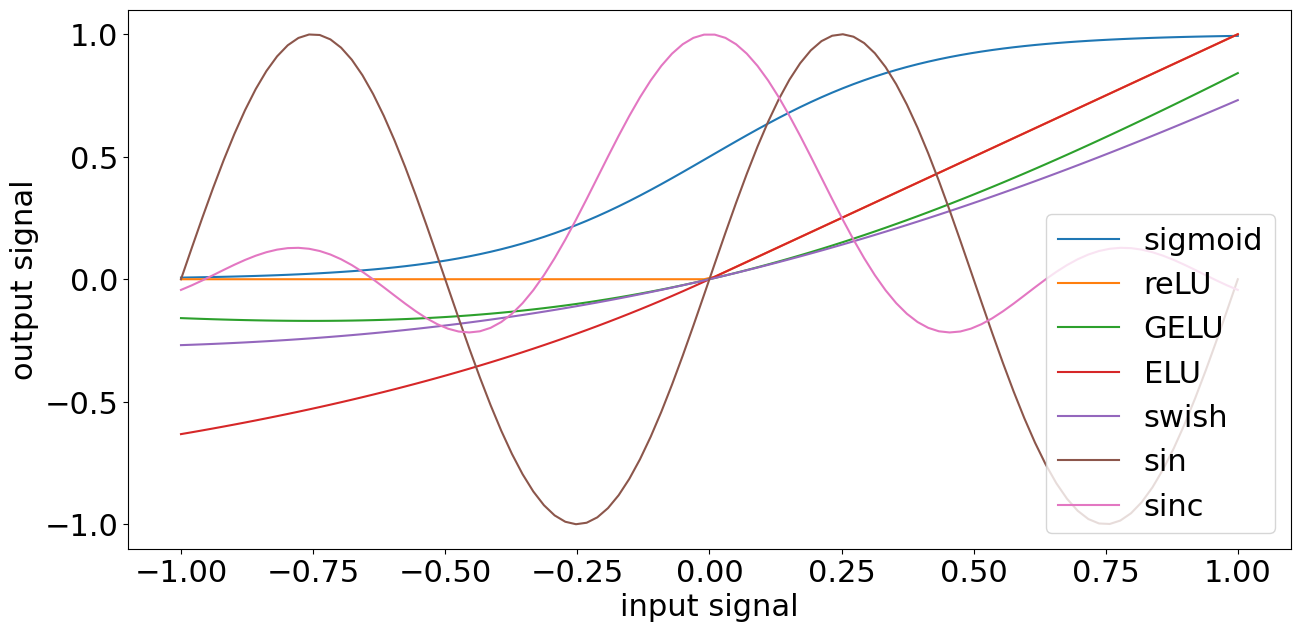

In [5]:
#
# relu, sigmoid and softmax optimization functions
#
x=np.linspace(-1,1,100)
plt.figure(figsize=(15,7))
plt.plot(x,sigmoid(5*x),label='sigmoid')
plt.plot(x,relu(x),label='reLU')
plt.plot(x,gelu(x),label='GELU')
plt.plot(x,elu(x),label='ELU')
plt.plot(x,swish(x),label='swish')
plt.plot(x,np.sin(2*np.pi*x),label='sin')
plt.plot(x,np.sinc(np.pi*x),label='sinc')
plt.xlabel('input signal')
plt.ylabel('output signal')
plt.legend()
plt.savefig('activation.pdf')
files.download('activation.pdf')

For ${\bf f}\in \mathbb{R}^2$, the  perceptron separates the 2D plane with a line. Here we suppose for example that
 $${\bf w}=\begin{bmatrix}0.5\\0.25\end{bmatrix}$$
 and $b=0.2$

In [11]:
def grelu(x,y, w, b):
    gv=get_value(relu([w[0]*x+w[1]*y+b]))
    return gv
def ggelu(x,y, w, b):
    gv=get_value(gelu([w[0]*x+w[1]*y+b]))
    return gv
def gsigmoid(x,y, w, b):
    gv=get_value(sigmoid([w[0]*x+w[1]*y+b]))
    return gv
def gsin(x,y, w, b):
    gv=np.sin(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gj0(x,y, w, b):
    gv=j0(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gSinc(x,y, w, b):
    gv=tf.experimental.numpy.sinc(np.pi*(w[0]*x+w[1]*y+b))
    return gv


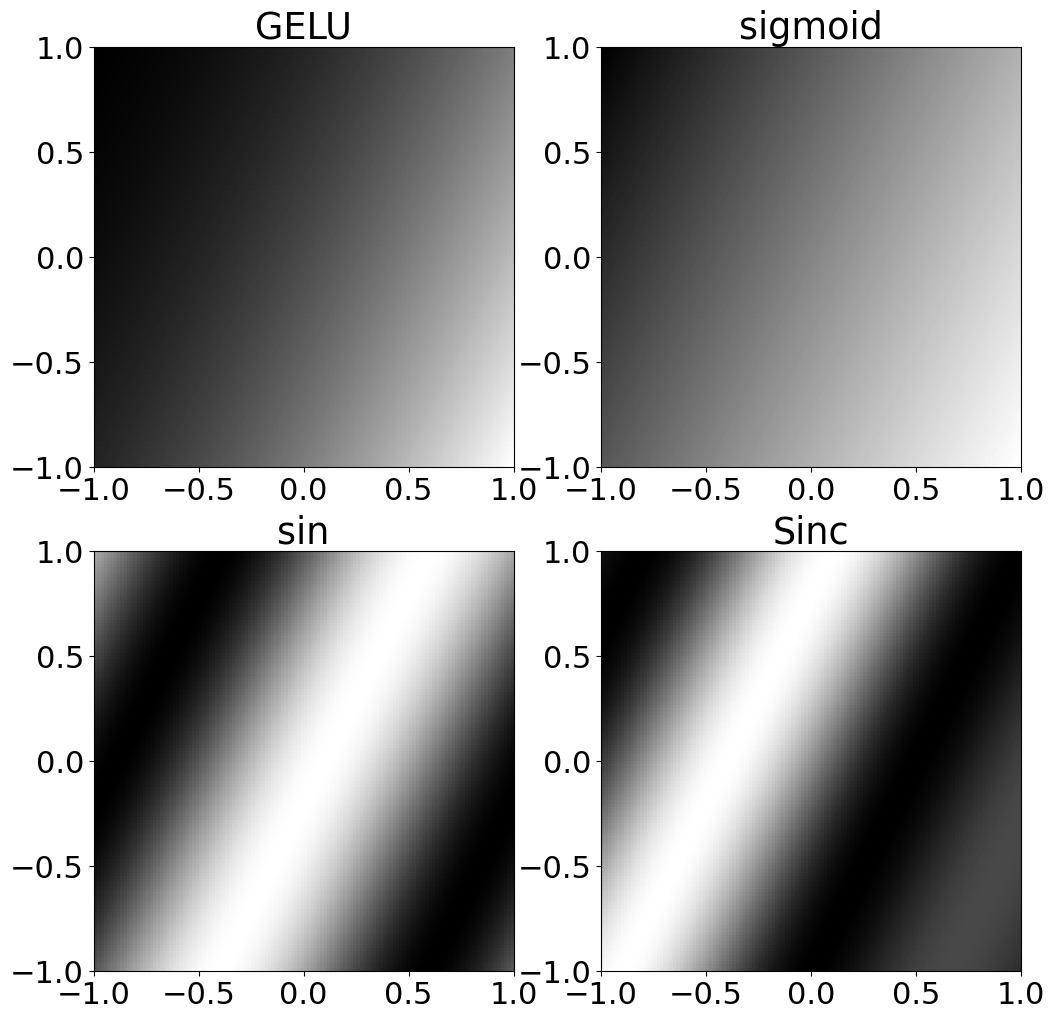

In [12]:
xRange=np.linspace(-1,1,128)
x,y=np.meshgrid(xRange,xRange)
w=[0.5,0.25]
b=0.2
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
pop=ggelu(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('GELU')
plt.subplot(2,2,2)
pop=gsigmoid(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sigmoid')
plt.subplot(2,2,3)
pop=gsin(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
pop=gSinc(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('Sinc')
plt.savefig('2nodeSegmentation.pdf')

## Multilayer Perceptrons

A multilayer perceptron is a feedforward neural network  with an input layer, hidden layers and an output layer. MLP can be trained to implement arbitrary mappings between the input and output layers.

In [13]:
coords=tf.stack((x,y))
coords=tf.reshape(coords,[2,-1])
coords=tf.transpose(coords)

In [14]:
inputs=layers.Input(shape=( 2,))
initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=15)
x1S=layers.Dense(256, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(inputs)
x2S=layers.Dense(16, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x1S)
x3S=layers.Dense(8, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x2S)
x4S=layers.Dense(1, activation=tf.math.sin,kernel_initializer=initializer,trainable=False)(x3S)
mlpSin=Model(inputs,x4S)
x1G=layers.Dense(256, activation='gelu',kernel_initializer=initializer, trainable=False)(inputs)
x2G=layers.Dense(16, activation='gelu',kernel_initializer=initializer, trainable=False)(x1G)
x3G=layers.Dense(8, activation='gelu',kernel_initializer=initializer,trainable=False)(x2G)
x4G=layers.Dense(1, activation='gelu',kernel_initializer=initializer,trainable=False)(x3G)
mlpG=Model(inputs,x4G)
x1J=layers.Dense(256, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(inputs)
x2J=layers.Dense(16, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(x1J)
x3J=layers.Dense(8, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x2J)
x4J=layers.Dense(1, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x3J)
mlpJ=Model(inputs,x4J)


In [15]:
mlpSimage=mlpSin.predict(coords)
mlpGimage=mlpG.predict(coords)
mlpJimage=mlpJ.predict(coords)

512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


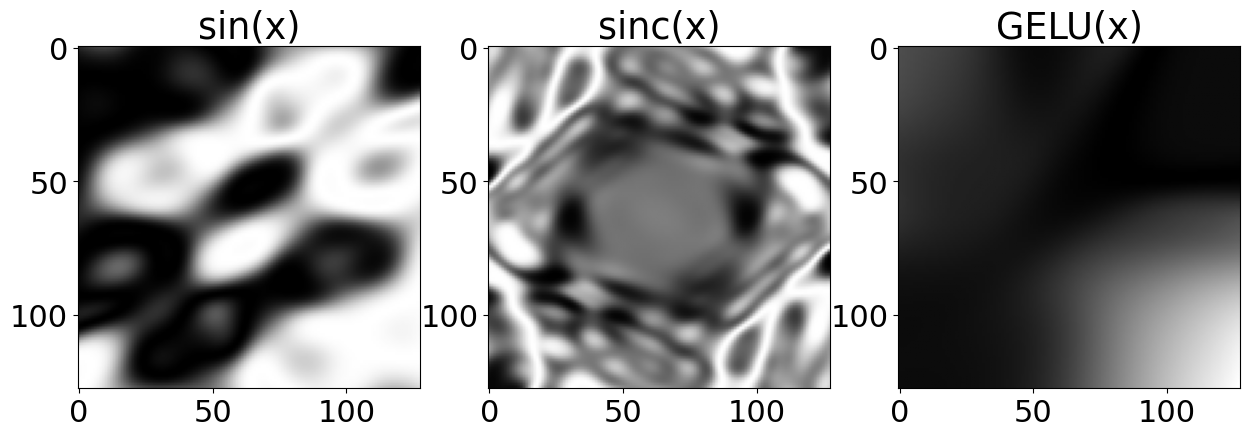

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(np.resize(mlpSimage,(128,128)),cmap='gray')
plt.title('sin(x)')
plt.subplot(1,3,2)
plt.imshow(np.resize(mlpJimage,(128,128)), cmap='gray')
plt.title('sinc(x)')
plt.subplot(1,3,3)
plt.imshow(np.resize(mlpGimage,(128,128)), cmap='gray')
plt.title('GELU(x)')
plt.savefig('mlpRandom.pdf')

## Learned neural representation

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


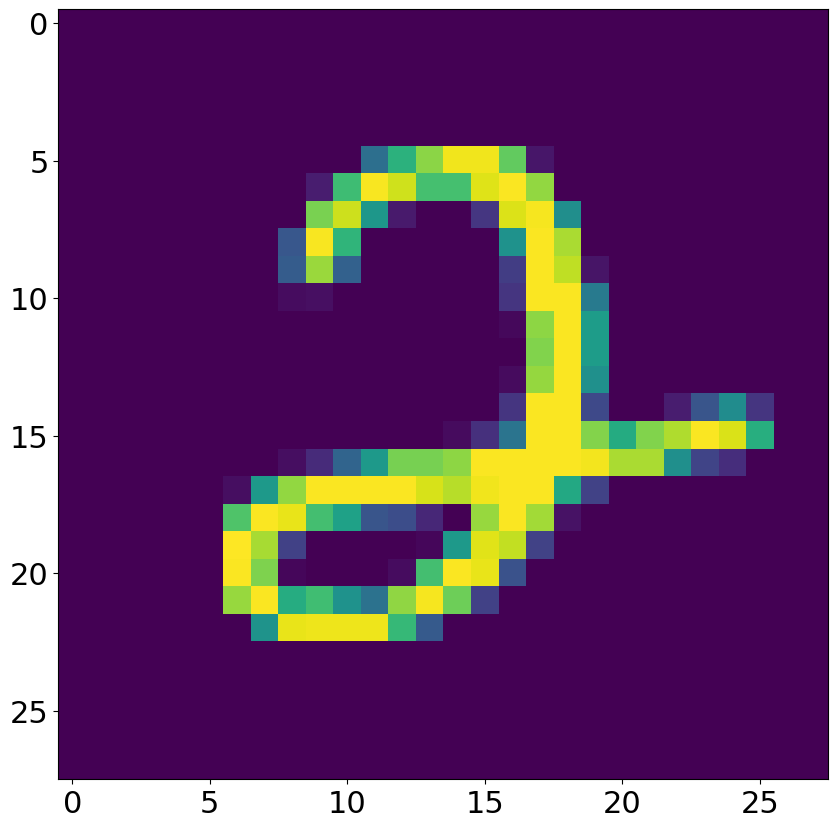

In [36]:
plt.imshow(x_train[16])


In [37]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [np.linspace(-1, 1, sidelen)])
    mgrid = np.stack(np.meshgrid(*tensors), -1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

pixels=x_train[16,:,:]/255.
coords = get_mgrid(pixels.shape[0], 2)
pixels=pixels.reshape(28*28,1)
coords= coords.reshape(28*28,2)

train_dataset = tf.data.Dataset.from_tensor_slices(( coords, pixels))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
upCoords=get_mgrid(256, 2)

## Siren

In [38]:

inputs=layers.Input(shape=( 2,))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.math.sin)(inputs)
x2=layers.Dense(4, activation=tf.math.sin)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
mlp.fit(train_dataset, epochs=1000)


Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8467 - loss: 0.0666
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8429 - loss: 0.0644
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8504 - loss: 0.0658
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8460 - loss: 0.0633
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8510 - loss: 0.0607
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8522 - loss: 0.0612
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8516 - loss: 0.0618 
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8447 - loss: 0.0626
Epoch 9/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.0633 
Epoch 10/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8400 - loss: 0.0654
Epoch 11/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.0606
Epoch 12/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [43]:
pip=mlp.predict(coords)
pipUp=mlp.predict(upCoords)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step


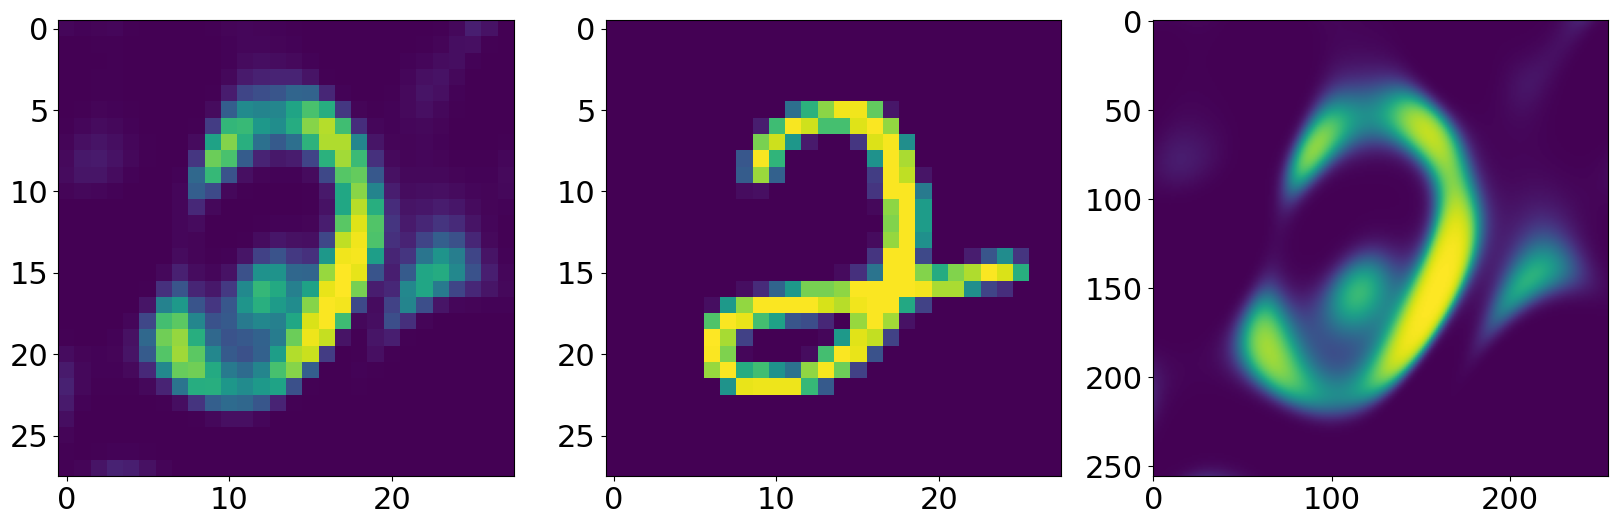

In [44]:
plt.subplot(1,3,1)
plt.imshow(pip.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(pipUp.reshape((256,256)))





## Sinc

In [45]:

inputs=layers.Input(shape=( 2,))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.experimental.numpy.sinc)(inputs)
x2=layers.Dense(4, activation=tf.experimental.numpy.sinc)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8526 - loss: 0.0789
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8448 - loss: 0.0713
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.0703 
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.0661
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.0692 
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8524 - loss: 0.0648
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - loss: 0.0638
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8509 - loss: 0.0640
Epoch 9/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8515 - loss: 0.0616
Epoch 10/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8399 - loss: 0.0654
Epoch 11/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.0613
Epoch 12/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

In [47]:
pap=mlp.predict(coords)
papUp=mlp.predict(upCoords)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


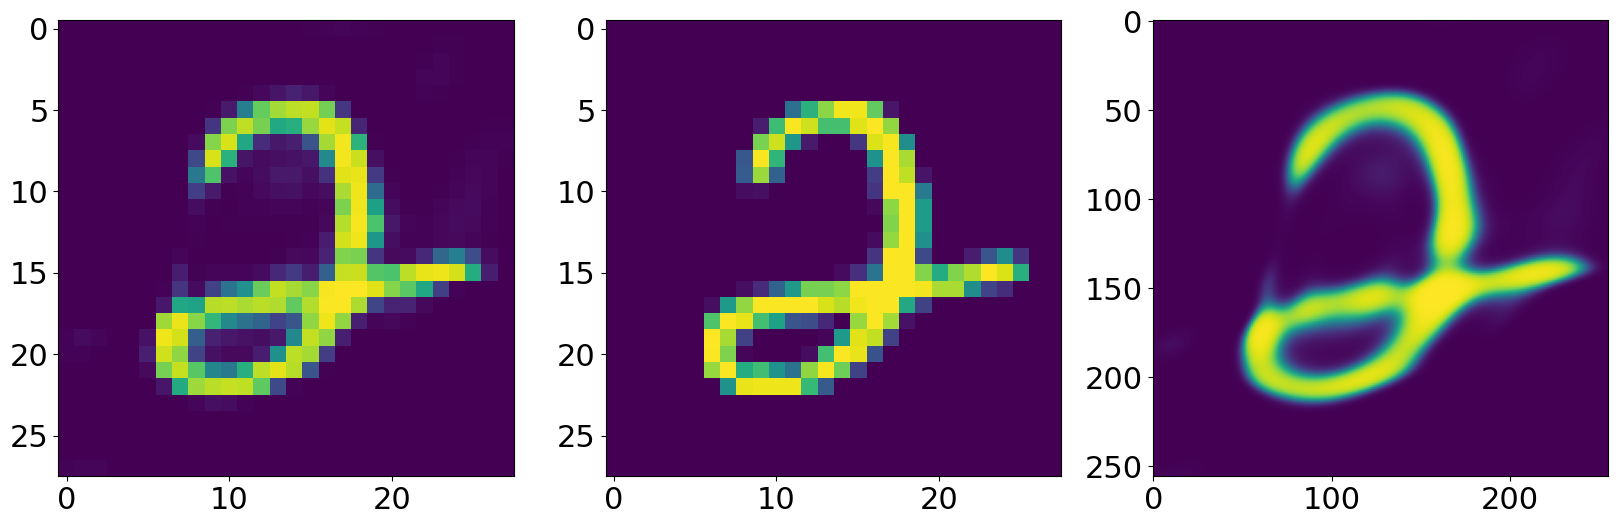

In [48]:
plt.subplot(1,3,1)
plt.imshow(pap.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(papUp.reshape((256,256)))

## Gelu

In [49]:
inputs=layers.Input(shape=( 2,))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation='gelu')(inputs)
x2=layers.Dense(4, activation='gelu')(x1)
x=layers.Dense(1, activation='sigmoid')(x2)


mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6992 - loss: 0.2239
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7923 - loss: 0.2007
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8292 - loss: 0.1823
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8589 - loss: 0.1636
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8467 - loss: 0.1437
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8512 - loss: 0.1250
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8570 - loss: 0.1074
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 0.0907
Epoch 9/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8538 - loss: 0.0812
Epoch 10/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8504 - loss: 0.0731
Epoch 11/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8479 - loss: 0.0724 
Epoch 12/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

In [51]:
pop=mlp.predict(coords)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


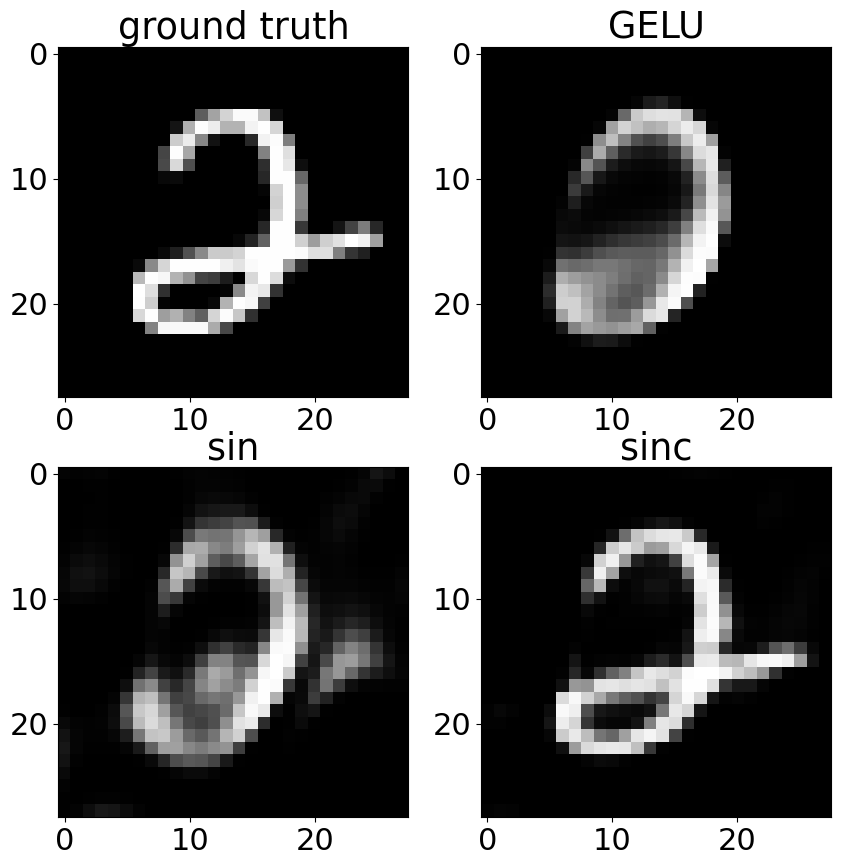

In [52]:
plt.figure(figsize=(10,10))
pop=mlp.predict(coords)
plt.subplot(2,2,1)
plt.imshow(pixels.reshape((28,28)), cmap='gray')
plt.title('ground truth')
plt.subplot(2,2,2)
plt.imshow(pop.reshape((28,28)), cmap='gray')
plt.title('GELU')
plt.subplot(2,2,3)
plt.imshow(pip.reshape((28,28)), cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
plt.imshow(pap.reshape((28,28)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNR.pdf')



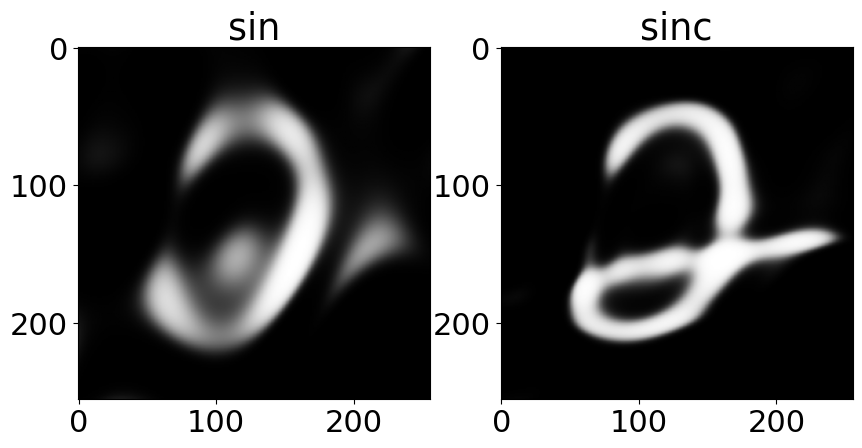

In [53]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(pipUp.reshape((256,256)), cmap='gray')
plt.title('sin')
plt.subplot(1,2,2)
plt.imshow(papUp.reshape((256,256)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNRup.pdf')